In [15]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import seaborn as sns
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

**Завантаження даних**
-
Датасет формується як характеристики (фактор-змінних) сегменту у 6 сек (30 вимірів акселерометру) діяльності людини.

In [2]:
df_cols = ['exercise', 'x_max', 'x_min', 'x_iqr', 'y_max', 'y_min_index',
           'y_mad', 'y_median', 'y_skew', 'y_std', 'z_skew']
df = pd.DataFrame(columns=df_cols)

data_dir = "data"
data_path = Path(data_dir)
assert data_path.is_dir(), f"Folder '{data_dir}' is absent"
exercise_name=[]
exercise_num = 0
for exercise in data_path.iterdir():
    if exercise.is_file(): next
    print(exercise.name)
    i = 1
    table = exercise / f"{exercise.name}-{i}.csv"
    exercise_name.append(exercise.name) 
    while table.is_file():
        """
        1. x_max
        2. x_min
        ?. x_entropy ???
        3. x_iqr
        4. y_max
        5. y_min_index
        6. y_mad - average of absolute deviation
        7. y_median
        8. y_skew - skewness
        9. y_std - standard deviation
        ?. y_rmse - root of mean square error ???
        10. z_skew
        """
        sdf = pd.read_csv(table)
        #{{{ Count features
        x_max = sdf['accelerometer_X'].max()
        x_min = sdf['accelerometer_X'].min()
        quartiles = sdf['accelerometer_X'].quantile([0.25, 0.75])
        x_iqr = quartiles[0.75] - quartiles[0.25]
        y_max = sdf['accelerometer_Y'].max()
        y_min_index = sdf['accelerometer_Y'].idxmin()
        y_mad = abs(sdf['accelerometer_Y'] - sdf['accelerometer_Y'].mean()).mean()
        y_median = sdf['accelerometer_Y'].median()
        y_skew = sdf['accelerometer_Y'].skew()
        y_std = sdf['accelerometer_Y'].std(ddof=0)
        z_skew = sdf['accelerometer_Z'].skew()
        #}}}
        df.loc[len(df.index)] = [exercise_num,
                                 x_max, x_min, x_iqr, y_max, y_min_index, y_mad, y_median, y_skew, y_std, z_skew]
        i += 1
        table = exercise / f"{exercise.name}-{i}.csv"
    exercise_num += 1
df.shape

stairs
walking
idle
running


(6462, 11)

In [4]:
mms = MinMaxScaler()
df[df_cols[1:]] = mms.fit_transform(df[df_cols[1:]])
df

exercise     x_max     x_min     x_iqr     y_max  y_min_index     y_mad  \
0          0.0  0.216825  0.861485  0.161500  0.167987     0.655172  0.195152   
1          0.0  0.216825  0.861485  0.148495  0.088559     0.586207  0.164154   
2          0.0  0.222249  0.861485  0.148042  0.088559     0.517241  0.156297   
3          0.0  0.222249  0.861485  0.152276  0.088559     0.965517  0.171520   
4          0.0  0.222249  0.861485  0.160492  0.088559     0.896552  0.170333   
...        ...       ...       ...       ...       ...          ...       ...   
6457       3.0  0.654453  0.706759  0.513030  0.894609     0.068966  0.660718   
6458       3.0  0.654453  0.848015  0.450376  0.894609     0.000000  0.646873   
6459       3.0  0.654453  0.848015  0.418015  0.894609     0.310345  0.560439   
6460       3.0  0.654453  0.848015  0.379555  0.894609     0.241379  0.512843   
6461       3.0  0.654453  0.909524  0.379555  0.894609     0.172414  0.498074   

      y_median    y_skew     y_std    z_skew  
0     0.204419  0.475174  0.236608  0.466654  
1     0.195261  0.430787  0.202766  0.456754  
2     0.188876  0.429339  0.193151  0.459834  
3     0.176021  0.420843  0.213406  0.450488  
4     0.176021  0.421103  0.212458  0.455019  
...        ...       ...       ...       ...  
6457  0.658461  0.528337  0.702100  0.574930  
6458  0.706016  0.525178  0.695797  0.572063  
6459  0.658461  0.532052  0.616230  0.574403  
6460  0.658461  0.529516  0.580400  0.573574  
6461  0.696102  0.525541  0.571005  0.554559  

[6462 rows x 11 columns]

In [5]:
df.describe()

exercise        x_max        x_min        x_iqr        y_max  \
count  6462.000000  6462.000000  6462.000000  6462.000000  6462.000000   
mean      2.190034     0.420170     0.751621     0.302410     0.510941   
std       0.937997     0.344348     0.172299     0.199317     0.331819   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       1.000000     0.088827     0.672607     0.156182     0.180088   
50%       3.000000     0.319031     0.794731     0.301174     0.645215   
75%       3.000000     0.729782     0.856360     0.452543     0.808031   
max       3.000000     1.000000     1.000000     1.000000     1.000000   

       y_min_index        y_mad     y_median       y_skew        y_std  \
count  6462.000000  6462.000000  6462.000000  6462.000000  6462.000000   
mean      0.490902     0.391856     0.509754     0.506451     0.423251   
std       0.300637     0.229499     0.287048     0.066920     0.243161   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.241379     0.230015     0.146782     0.479101     0.250196   
50%       0.482759     0.422891     0.665602     0.502029     0.464158   
75%       0.758621     0.576525     0.740695     0.528695     0.617956   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

            z_skew  
count  6462.000000  
mean      0.537699  
std       0.114977  
min       0.000000  
25%       0.478460  
50%       0.546327  
75%       0.607763  
max       1.000000

In [6]:
exercise_name

['stairs', 'walking', 'idle', 'running']

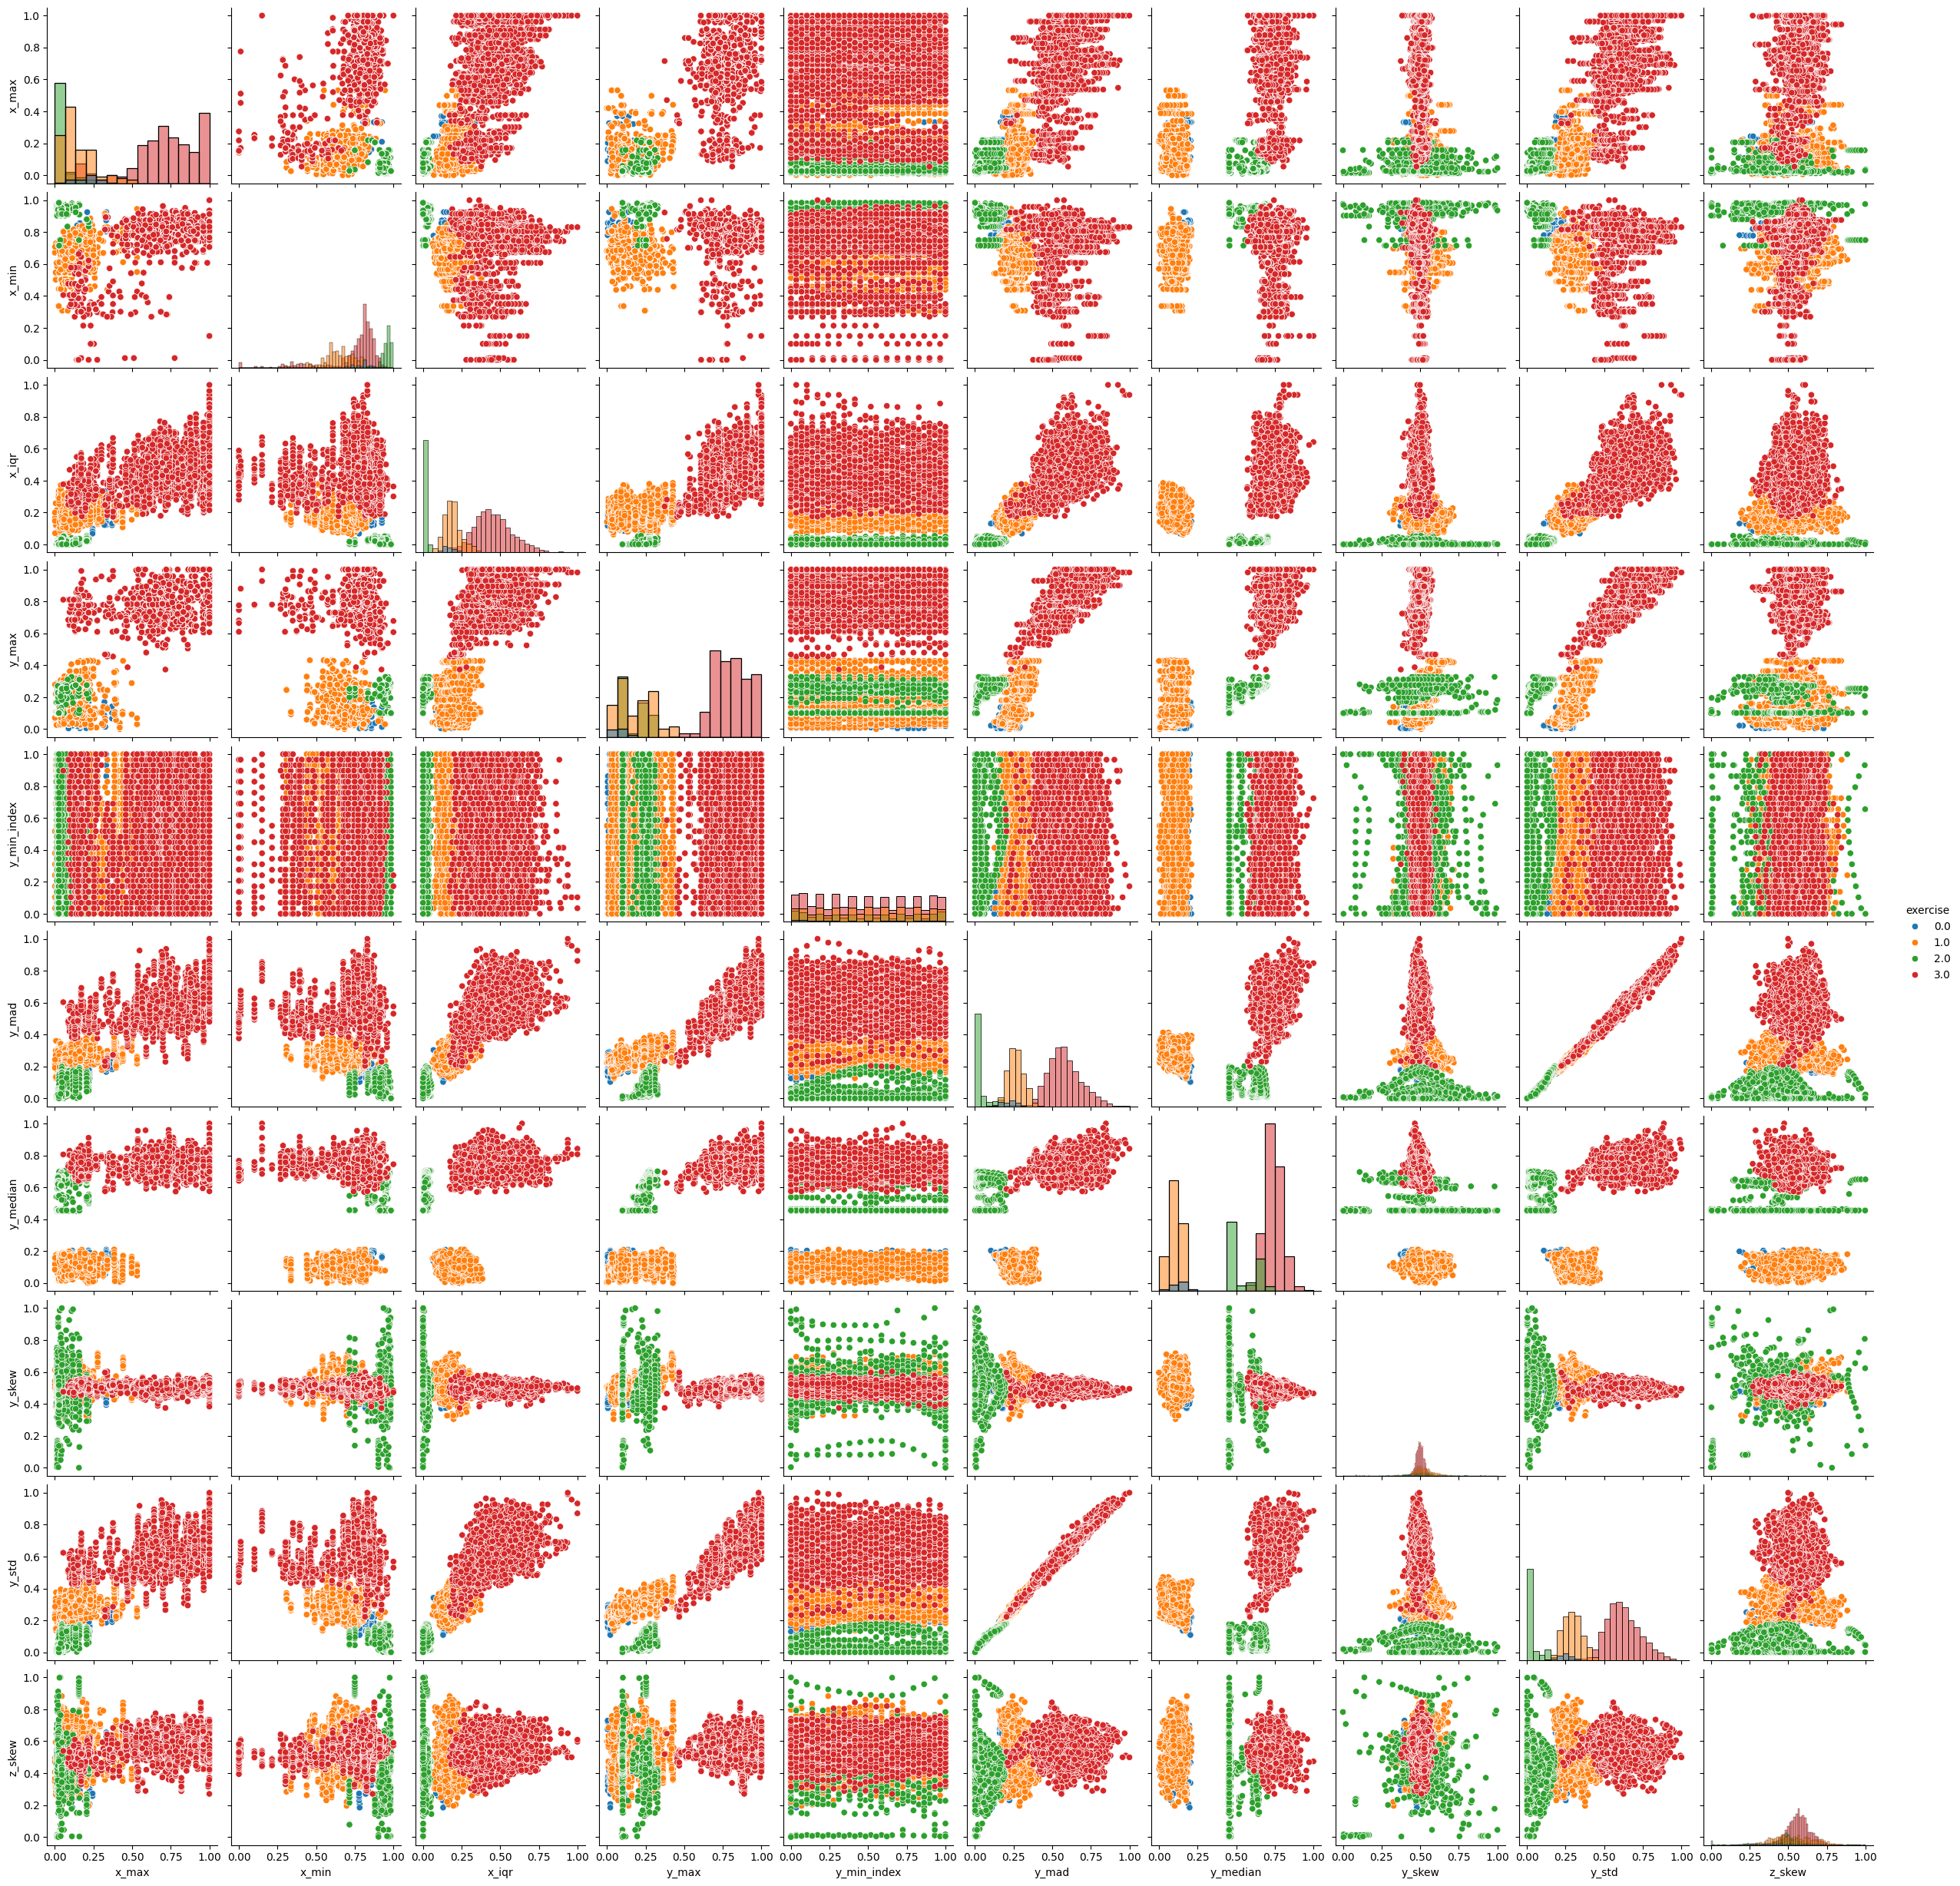

In [85]:
sns.pairplot(df, hue='exercise', palette= "tab10", diag_kind='hist')

**Розподіл вибірки на навчальну та тестову**
-

In [7]:
train, test = train_test_split(df, test_size=0.2, shuffle=True)
Xtr = train[df_cols[1:]]
ytr = train['exercise']
Xts = test[df_cols[1:]]
yts = test['exercise']
train.shape[0], test.shape[0]

(5169, 1293)

**SVM RBF** Model
-

In [10]:
c_svmrbf = svm.SVC(kernel="rbf")
c_svmrbf.fit(Xtr, ytr)
c_svmrbf_preds = c_svmrbf.predict(Xts)
c_svmrbf_cm = confusion_matrix(np.asarray(yts), np.asarray(c_svmrbf_preds))
c_svmrbf_cm

array([[  7,  24,   0,   0],
       [  1, 386,   0,   0],
       [  0,   0, 222,   0],
       [  0,   0,   0, 653]])

In [11]:
c_svmrbf_acsc = accuracy_score(yts, c_svmrbf_preds)
c_svmrbf_acsc

0.9806651198762568

**SVM Linear** Model
-

In [13]:
c_svmlin = svm.SVC(kernel="linear")
c_svmlin.fit(Xtr, ytr)
c_svmlin_preds = c_svmlin.predict(Xts)
c_svmlin_cm = confusion_matrix(np.asarray(yts), np.asarray(c_svmlin_preds))
c_svmlin_cm

array([[  0,  31,   0,   0],
       [  0, 387,   0,   0],
       [  0,   0, 222,   0],
       [  0,   0,   0, 653]])

In [14]:
c_svmlin_acsc = accuracy_score(yts, c_svmlin_preds)
c_svmlin_acsc

0.9760247486465584

**Random Forest** Model
-

In [102]:
c_rf = RandomForestClassifier(n_estimators=50)
c_rf.fit(Xtr, ytr)
c_rf_preds = c_rf.predict(Xts)
c_rf_cm = confusion_matrix(np.asarray(yts), np.asarray(c_rf_preds))
c_rf_cm

array([[ 28,   3,   0,   0],
       [  0, 387,   0,   0],
       [  0,   0, 222,   0],
       [  0,   0,   0, 653]])

In [103]:
c_rf_acsc = accuracy_score(yts, c_rf_preds)
c_rf_acsc

0.9976798143851509

**Порівняння**
-

In [104]:
print("Точність:\n"
     f"Модель SVM (RBF)    : {c_svmrbf_acsc}\n"
     f"Модель SVM (Linear) : {c_svmlin_acsc}\n"
     f"Модель Random Forest: {c_rf_acsc}")

Точність:
Модель SVM (RBF)    : 0.9806651198762568
Модель SVM (Linear) : 0.9760247486465584
Модель Random Forest: 0.9976798143851509
